# Week - 43

In [2]:
import pandas as pd

df = pd.read_csv('../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv')
df = df.sort_values('Nodes', ascending=False)
df

,Foodweb,Nodes,Edges,Connectance,ecosystem.type
289,Chesapeake Bay_tax_mass,521,15746,0.058120,marine
288,Weddell Sea_tax_mass,490,16041,0.066946,marine
287,Lough Hyne_tax_mass,346,5052,0.042322,marine
286,Kongsfjorden_tax_mass,263,1603,0.023264,marine
285,Caribbean Reef_tax_mass,247,3311,0.054491,marine
...,...,...,...,...,...
4,SF1M1_tax_mass,12,28,0.212121,marine
3,PC2P5_tax_mass,12,33,0.250000,marine
2,SP1_tax_mass,11,24,0.218182,marine
1,PP1I3_tax_mass,11,24,0.218182,marine


## Metric vs Nodes by Ecosystem Type (TrainRatio = 80%)

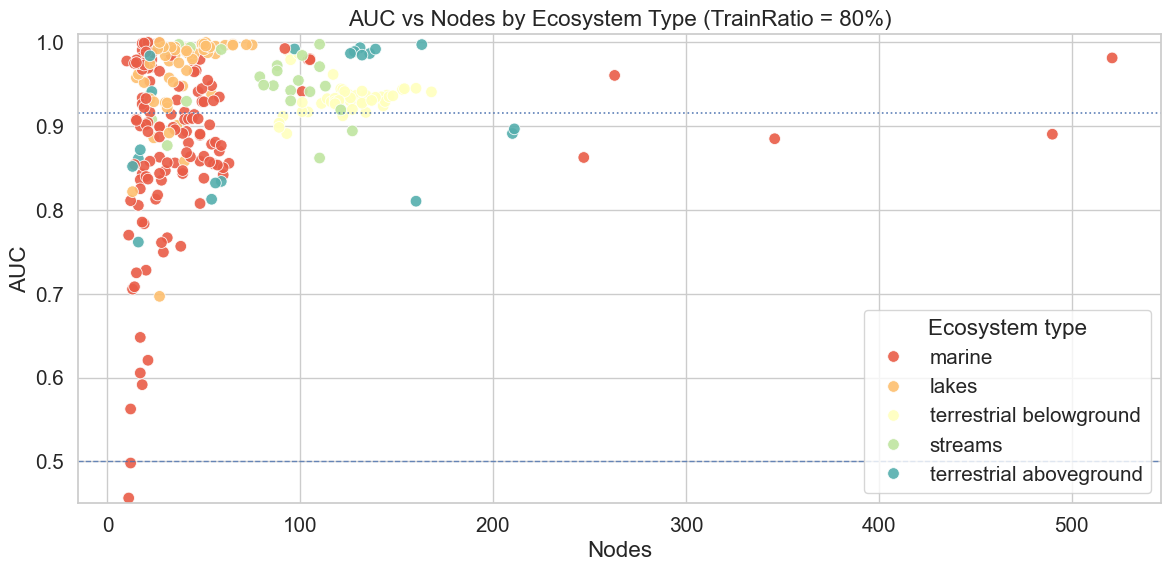

AUC: points plotted = 290, mean = 0.9160


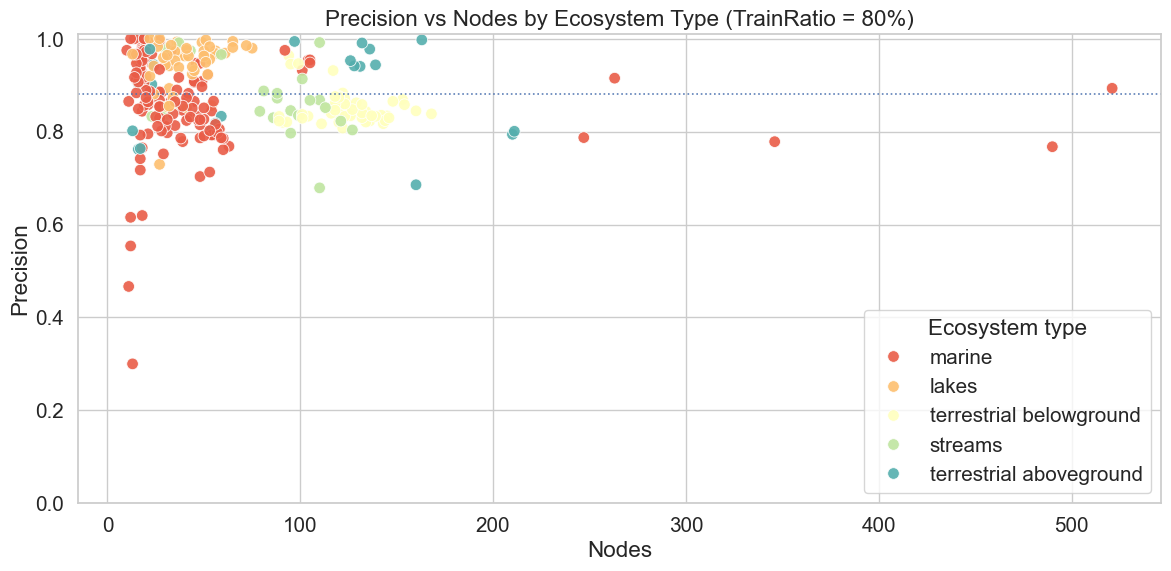

Precision: points plotted = 290, mean = 0.8819


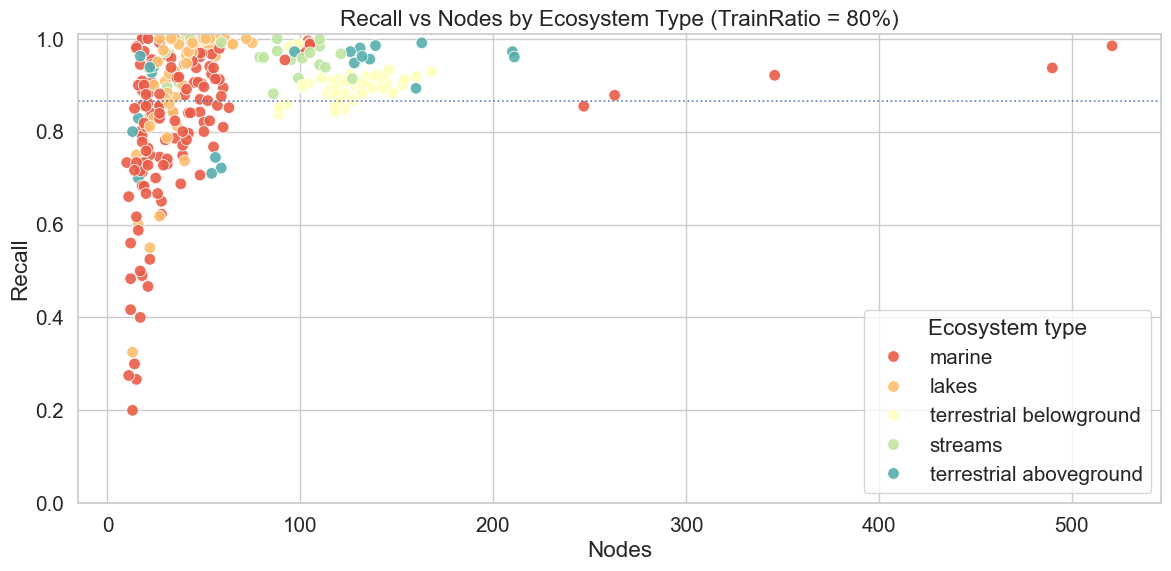

Recall: points plotted = 290, mean = 0.8663


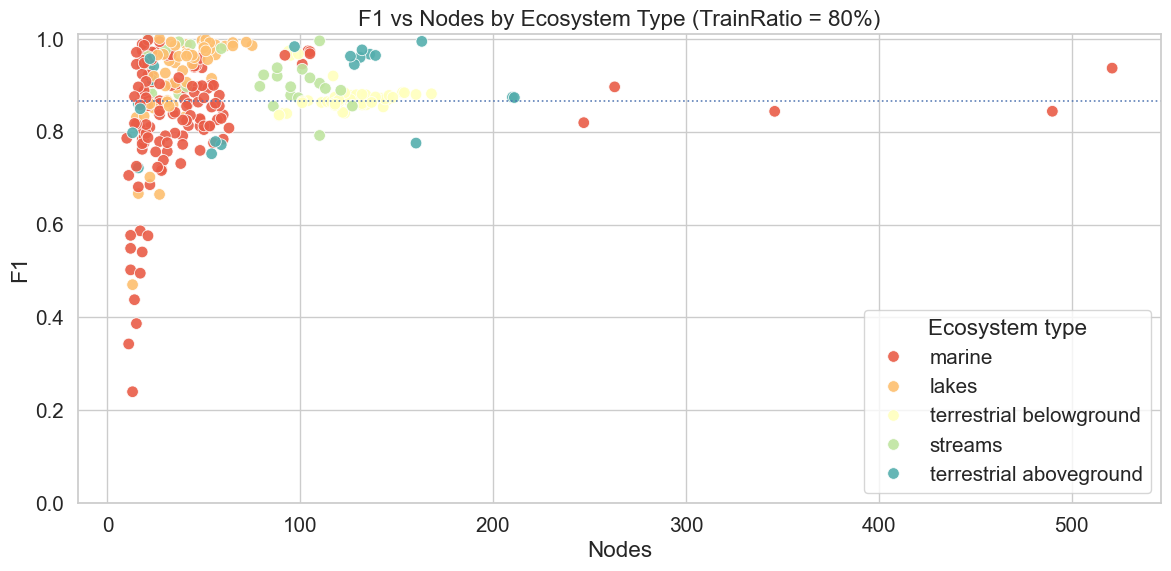

F1: points plotted = 290, mean = 0.8655


In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Paths ===
results_dir = "../../src/matlab/data/result_sweep_train_ratios_290/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"

# === Controls ===
MIN_NODES   = 1       # exclude food webs smaller than this
TRAIN_RATIO = 80.0    # visualize this train ratio (accepts 80 or 0.8 in data)
USE_LOG_X   = False   # set True if network sizes span orders of magnitude

# Metrics to loop over
metrics_to_plot = ["AUC", "Precision", "Recall", "F1"]

# === Load ecosystem metadata ===
df_ecosystem = pd.read_csv(ecosystem_file)

def _normalize(s: str) -> str:
    return (
        str(s).strip().lower()
        .replace(" ", "")
        .replace(".", "")
        .replace("-", "")
        .replace("_", "")
    )

# Detect node-count column robustly
node_candidates = {"nodes"}
norm_map = {_normalize(c): c for c in df_ecosystem.columns}
node_col = None
for k in node_candidates:
    if k in norm_map:
        node_col = norm_map[k]
        break
if node_col is None:
    raise RuntimeError("No node-count column found. Add one (e.g., 'nodes', 'S').")

# === Load result CSVs and stack ===
csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
if not csv_files:
    raise RuntimeError("No result CSV found. Check the path/pattern.")
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    df["Foodweb"] = os.path.basename(file).split("_results_")[0]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

# === Merge metadata (ecosystem + node count) ===
meta_cols = ["Foodweb", "ecosystem.type", node_col]
missing_cols = [c for c in meta_cols if c not in df_ecosystem.columns]
if missing_cols:
    raise RuntimeError(f"Missing columns in ecosystem metadata: {missing_cols}")
df_merged = pd.merge(df_all, df_ecosystem[meta_cols], on="Foodweb", how="left")

# === Filter by node count ===
df_merged[node_col] = pd.to_numeric(df_merged[node_col], errors="coerce")
df_merged = df_merged[df_merged[node_col] >= MIN_NODES].copy()

# === Handle TrainRatio stored as 80 or 0.8 ===
df_merged["TrainRatio_num"] = pd.to_numeric(df_merged["TrainRatio"], errors="coerce")
tr = df_merged["TrainRatio_num"]
mask_tr = np.isclose(tr, TRAIN_RATIO) | np.isclose(tr * 100.0, TRAIN_RATIO)
subset = df_merged[mask_tr].copy()

if subset.empty:
    raise RuntimeError("No rows after TrainRatio filtering. Verify TrainRatio values and units (80 vs 0.8).")

# === Metric aliases & helper ===
metric_aliases = {
    "AUC":        ["AUC", "auc"],
    "Precision":  ["Precision", "precision", "prec"],
    "Recall":     ["Recall", "recall", "tpr", "sensitivity"],
    "F1":         ["F1Score", "F1", "f1", "F1_Score"],
}

def find_col(df, cands):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in cands:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

# === Plot loop ===
sns.set_theme(style="whitegrid", font_scale=1.35)

for Metric in metrics_to_plot:
    # pick the right column for this metric
    metric_col = find_col(subset, metric_aliases[Metric])
    if metric_col is None:
        print(f"[WARN] Skipping {Metric}: none of {metric_aliases[Metric]} found in columns.")
        continue

    tmp = subset.copy()
    tmp[metric_col] = pd.to_numeric(tmp[metric_col], errors="coerce")
    tmp = tmp.dropna(subset=[metric_col, node_col, "ecosystem.type", "Foodweb"])

    # average per foodweb
    meta_unique = df_ecosystem[["Foodweb", "ecosystem.type", node_col]].drop_duplicates()
    metric_avg = (
        tmp.groupby("Foodweb", as_index=False)[metric_col]
           .mean()
           .rename(columns={metric_col: "MetricValue"})
        .merge(meta_unique, on="Foodweb", how="left")
        .dropna(subset=["MetricValue", node_col, "ecosystem.type"])
    )

    # ordering for legend/palette
    ecosystem_order = (
        metric_avg[["Foodweb", "ecosystem.type"]]
        .drop_duplicates()
        .groupby("ecosystem.type")
        .size()
        .sort_values(ascending=False)
        .index
        .tolist()
    )

    palette = sns.color_palette("Spectral", n_colors=max(3, len(ecosystem_order)))

    # plot
    plt.figure(figsize=(12, 6))
    ax = sns.scatterplot(
        data=metric_avg,
        x=node_col, y="MetricValue",
        hue="ecosystem.type",
        hue_order=ecosystem_order,
        palette=palette,
        s=70, alpha=0.9,
        edgecolor="white", linewidth=0.6
    )

    # reference lines
    if Metric.upper() == "AUC":
        ax.axhline(0.5, linestyle="--", linewidth=1, alpha=0.8)  # random ROC-AUC baseline
    ax.axhline(metric_avg["MetricValue"].mean(), linestyle=":", linewidth=1.2, alpha=0.9)

    # axes & scales
    if USE_LOG_X:
        ax.set_xscale("log")
        ax.set_xlabel("Nodes (log scale)")
    else:
        ax.set_xlabel("Nodes")

    ax.set_ylabel(Metric)
    ax.set_title(f"{Metric} vs Nodes by Ecosystem Type (TrainRatio = {int(TRAIN_RATIO)}%)")

    ymin = 0.45 if Metric.upper() == "AUC" else 0.0
    ax.set_ylim(ymin, 1.01)

    # legend
    leg = ax.legend(title="Ecosystem type", frameon=True, loc="lower right")
    for lh in getattr(leg, "legend_handles", []):
        try:
            lh.set_sizes([70])
        except Exception:
            pass

    plt.tight_layout()
    plt.show()

    print(f"{Metric}: points plotted = {len(metric_avg)}, mean = {metric_avg['MetricValue'].mean():.4f}")

## Metric vs Nodes by Ecosystem Type (TrainRatio = 80%) 2x2

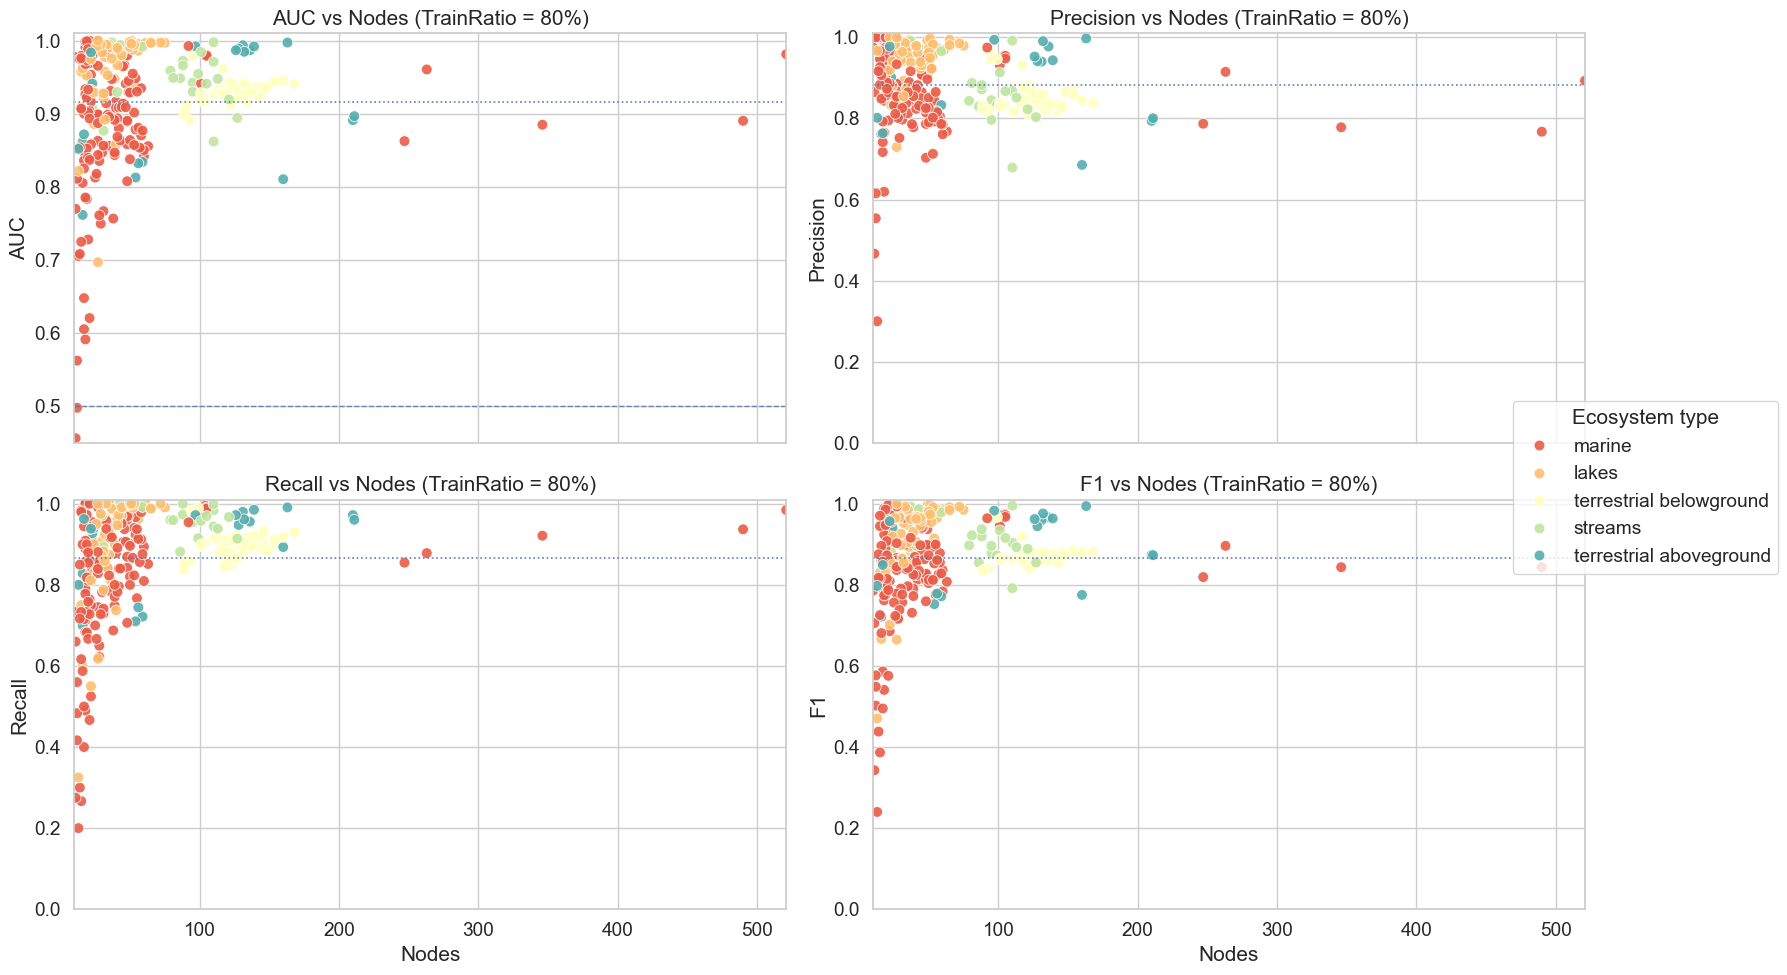

In [3]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Paths ===
results_dir = "../../src/matlab/data/result_sweep_train_ratios_290/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"

# === Controls ===
MIN_NODES   = 1
TRAIN_RATIO = 80.0
USE_LOG_X   = False

metrics_to_plot = ["AUC", "Precision", "Recall", "F1"]
metric_aliases = {
    "AUC":        ["AUC", "auc"],
    "Precision":  ["Precision", "precision", "prec"],
    "Recall":     ["Recall", "recall", "tpr", "sensitivity"],
    "F1":         ["F1Score", "F1", "f1", "F1_Score"],
}

# === Load ecosystem metadata ===
df_ecosystem = pd.read_csv(ecosystem_file)

def _normalize(s: str) -> str:
    return (
        str(s).strip().lower()
        .replace(" ", "").replace(".", "").replace("-", "").replace("_", "")
    )

# robust node-count detection
node_candidates = {
    "nodes","n_nodes","num_nodes","species","numspecies","s","nodecount","speciescount"
}
norm_map = {_normalize(c): c for c in df_ecosystem.columns}
node_col = None
for k in node_candidates:
    if k in norm_map:
        node_col = norm_map[k]
        break
if node_col is None:
    raise RuntimeError("No node-count column found. Add one (e.g., 'nodes' or 'S').")

# === Load result CSVs and stack ===
csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
if not csv_files:
    raise RuntimeError("No result CSV found. Check the path/pattern.")
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    df["Foodweb"] = os.path.basename(file).split("_results_")[0]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

# === Merge metadata (ecosystem + node count) ===
meta_cols = ["Foodweb", "ecosystem.type", node_col]
missing_cols = [c for c in meta_cols if c not in df_ecosystem.columns]
if missing_cols:
    raise RuntimeError(f"Missing columns in ecosystem metadata: {missing_cols}")
df_merged = pd.merge(df_all, df_ecosystem[meta_cols], on="Foodweb", how="left")

# === Filter by node count ===
df_merged[node_col] = pd.to_numeric(df_merged[node_col], errors="coerce")
df_merged = df_merged[df_merged[node_col] >= MIN_NODES].copy()

# === TrainRatio: accept 80 or 0.8 ===
df_merged["TrainRatio_num"] = pd.to_numeric(df_merged["TrainRatio"], errors="coerce")
tr = df_merged["TrainRatio_num"]
mask_tr = np.isclose(tr, TRAIN_RATIO) | np.isclose(tr * 100.0, TRAIN_RATIO)
subset = df_merged[mask_tr].copy()
if subset.empty:
    raise RuntimeError("No rows after TrainRatio filtering (check 80 vs 0.8).")

# Shared legend order & palette
eco_order = (
    subset[["Foodweb", "ecosystem.type"]]
    .drop_duplicates()
    .groupby("ecosystem.type").size()
    .sort_values(ascending=False).index.tolist()
)
palette = sns.color_palette("Spectral", n_colors=max(3, len(eco_order)))

def find_col(df, cands):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in cands:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

# Precompute global x-limits
x_all = subset[node_col].astype(float)
x_min, x_max = np.nanmin(x_all), np.nanmax(x_all)

# === Create 2x2 grid ===
sns.set_theme(style="whitegrid", font_scale=1.25)
fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True)
axes_map = {
    "AUC": axes[0, 0],
    "Precision": axes[0, 1],
    "Recall": axes[1, 0],
    "F1": axes[1, 1],
}

shared_handles = {}
for Metric in metrics_to_plot:
    ax = axes_map[Metric]

    # locate metric column
    metric_col = find_col(subset, metric_aliases[Metric])
    if metric_col is None:
        ax.text(0.5, 0.5, f"{Metric} not found", ha="center", va="center", fontsize=14)
        ax.set_axis_off()
        continue

    tmp = subset.copy()
    tmp[metric_col] = pd.to_numeric(tmp[metric_col], errors="coerce")
    tmp = tmp.dropna(subset=[metric_col, node_col, "ecosystem.type", "Foodweb"])

    # average per foodweb
    meta_unique = df_ecosystem[["Foodweb", "ecosystem.type", node_col]].drop_duplicates()
    metric_avg = (
        tmp.groupby("Foodweb", as_index=False)[metric_col].mean()
          .rename(columns={metric_col: "MetricValue"})
          .merge(meta_unique, on="Foodweb", how="left")
          .dropna(subset=["MetricValue", node_col, "ecosystem.type"])
    )

    # scatter
    g = sns.scatterplot(
        data=metric_avg,
        x=node_col, y="MetricValue",
        hue="ecosystem.type", hue_order=eco_order, palette=palette,
        s=60, alpha=0.9, edgecolor="white", linewidth=0.6, ax=ax
    )

    # reference lines
    if Metric.upper() == "AUC":
        ax.axhline(0.5, linestyle="--", linewidth=1, alpha=0.8)
        y_min = 0.45
    else:
        y_min = 0.0
    ax.axhline(metric_avg["MetricValue"].mean(), linestyle=":", linewidth=1.2, alpha=0.9)

    # axes formatting
    if USE_LOG_X:
        ax.set_xscale("log")
        ax.set_xlabel("Nodes (log scale)")
    else:
        ax.set_xlabel("Nodes")

    ax.set_ylabel(Metric)
    ax.set_title(f"{Metric} vs Nodes (TrainRatio = {int(TRAIN_RATIO)}%)")
    ax.set_ylim(y_min, 1.01)
    ax.set_xlim(x_min, x_max)

    # === robust legend capture (works across seaborn/mpl versions) ===
    handles, labels = ax.get_legend_handles_labels()
    # drop the hue title if present as first label
    if labels and labels[0].lower() in {"ecosystem.type", "ecosystem type"}:
        handles, labels = handles[1:], labels[1:]
    # keep first-seen handle per label
    for h, lbl in zip(handles, labels):
        if lbl not in shared_handles:
            shared_handles[lbl] = h
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

# Shared legend (ordered by eco_order, only those present)
ordered_labels = [lbl for lbl in eco_order if lbl in shared_handles]
ordered_handles = [shared_handles[lbl] for lbl in ordered_labels]
if ordered_handles:
    fig.legend(ordered_handles, ordered_labels, title="Ecosystem type",
               loc="center right", frameon=True)

plt.tight_layout(rect=[0, 0, 0.90, 1])
plt.show()

## Metric vs Nodes by Ecosystem Type (TrainRatio = 80%) 2x2 - keep only points >= threshold

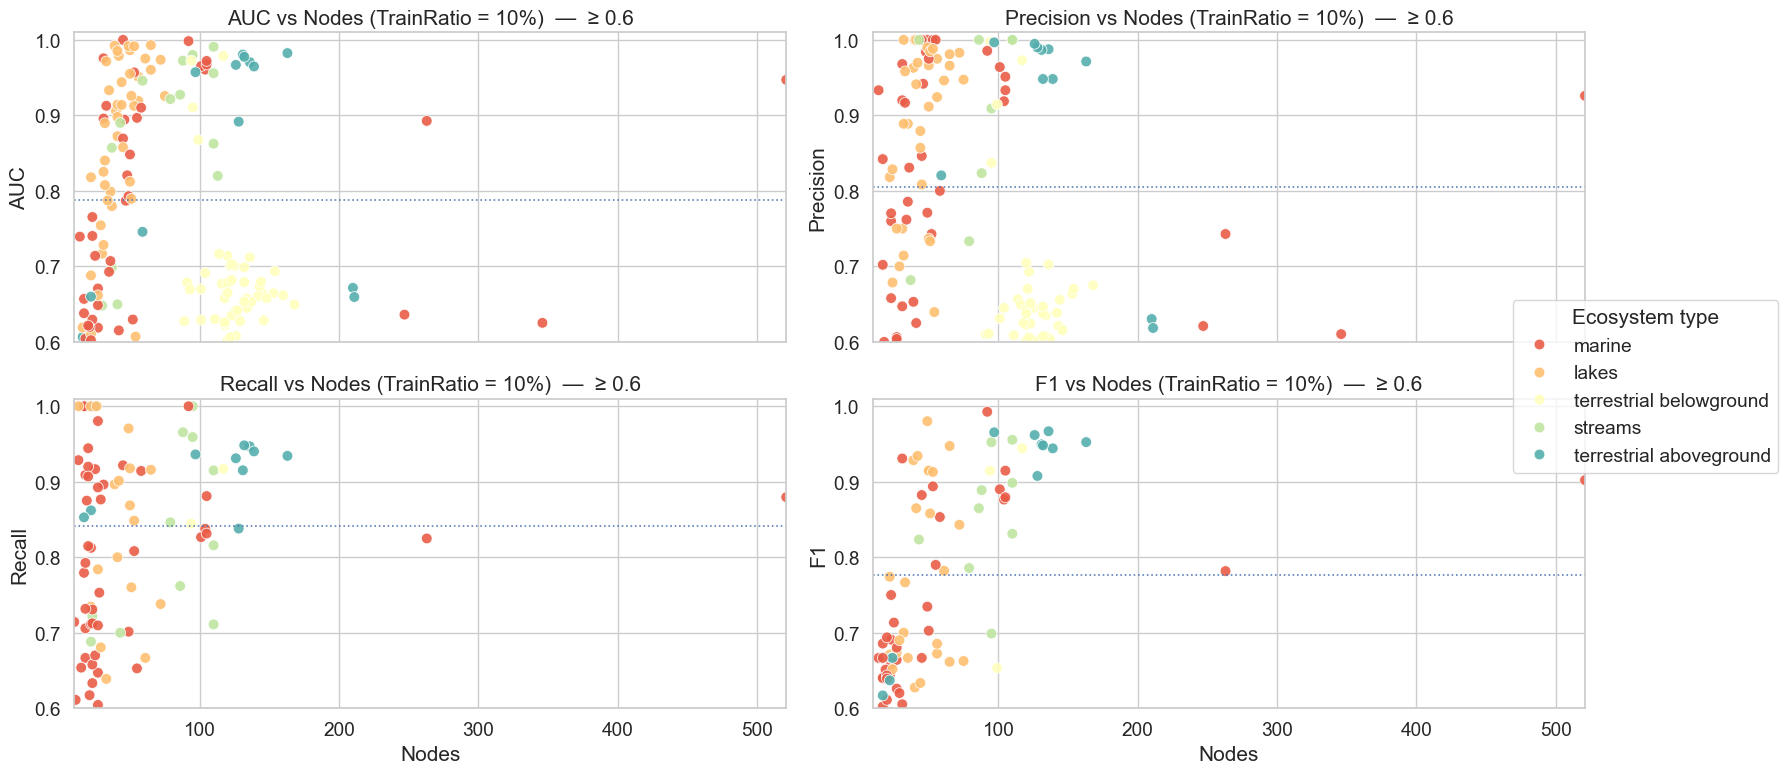

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Paths ===
results_dir = "../../src/matlab/data/result_sweep_train_ratios_10-90/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"

# === Controls ===
MIN_NODES   = 1
TRAIN_RATIO = 10.0
USE_LOG_X   = False
METRIC_MIN = 0.60   # show only foodwebs with metric >= this value

metrics_to_plot = ["AUC", "Precision", "Recall", "F1"]
metric_aliases = {
    "AUC":        ["AUC", "auc"],
    "Precision":  ["Precision", "precision", "prec"],
    "Recall":     ["Recall", "recall", "tpr", "sensitivity"],
    "F1":         ["F1Score", "F1", "f1", "F1_Score"],
}

# === Load ecosystem metadata ===
df_ecosystem = pd.read_csv(ecosystem_file)

def _normalize(s: str) -> str:
    return (
        str(s).strip().lower()
        .replace(" ", "").replace(".", "").replace("-", "").replace("_", "")
    )

# robust node-count detection
node_candidates = {
    "nodes","n_nodes","num_nodes","species","numspecies","s","nodecount","speciescount"
}
norm_map = {_normalize(c): c for c in df_ecosystem.columns}
node_col = None
for k in node_candidates:
    if k in norm_map:
        node_col = norm_map[k]
        break
if node_col is None:
    raise RuntimeError("No node-count column found. Add one (e.g., 'nodes' or 'S').")

# === Load result CSVs and stack ===
csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
if not csv_files:
    raise RuntimeError("No result CSV found. Check the path/pattern.")
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    df["Foodweb"] = os.path.basename(file).split("_results_")[0]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

# === Merge metadata (ecosystem + node count) ===
meta_cols = ["Foodweb", "ecosystem.type", node_col]
missing_cols = [c for c in meta_cols if c not in df_ecosystem.columns]
if missing_cols:
    raise RuntimeError(f"Missing columns in ecosystem metadata: {missing_cols}")
df_merged = pd.merge(df_all, df_ecosystem[meta_cols], on="Foodweb", how="left")

# === Filter by node count ===
df_merged[node_col] = pd.to_numeric(df_merged[node_col], errors="coerce")
df_merged = df_merged[df_merged[node_col] >= MIN_NODES].copy()

# === TrainRatio: accept 80 or 0.8 ===
df_merged["TrainRatio_num"] = pd.to_numeric(df_merged["TrainRatio"], errors="coerce")
tr = df_merged["TrainRatio_num"]
mask_tr = np.isclose(tr, TRAIN_RATIO) | np.isclose(tr * 100.0, TRAIN_RATIO)
subset = df_merged[mask_tr].copy()
if subset.empty:
    raise RuntimeError("No rows after TrainRatio filtering (check 80 vs 0.8).")

# Shared legend order & palette
eco_order = (
    subset[["Foodweb", "ecosystem.type"]]
    .drop_duplicates()
    .groupby("ecosystem.type").size()
    .sort_values(ascending=False).index.tolist()
)
palette = sns.color_palette("Spectral", n_colors=max(3, len(eco_order)))

def find_col(df, cands):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in cands:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

# Precompute global x-limits
x_all = subset[node_col].astype(float)
x_min, x_max = np.nanmin(x_all), np.nanmax(x_all)

# === Create 2x2 grid ===
sns.set_theme(style="whitegrid", font_scale=1.25)
fig, axes = plt.subplots(2, 2, figsize=(18, 8), sharex=True)
axes_map = {
    "AUC": axes[0, 0],
    "Precision": axes[0, 1],
    "Recall": axes[1, 0],
    "F1": axes[1, 1],
}

shared_handles = {}
for Metric in metrics_to_plot:
    ax = axes_map[Metric]

    metric_col = find_col(subset, metric_aliases[Metric])
    if metric_col is None:
        ax.text(0.5, 0.5, f"{Metric} not found", ha="center", va="center", fontsize=14)
        ax.set_axis_off()
        continue

    tmp = subset.copy()
    tmp[metric_col] = pd.to_numeric(tmp[metric_col], errors="coerce")
    tmp = tmp.dropna(subset=[metric_col, node_col, "ecosystem.type", "Foodweb"])

    meta_unique = df_ecosystem[["Foodweb", "ecosystem.type", node_col]].drop_duplicates()
    metric_avg = (
        tmp.groupby("Foodweb", as_index=False)[metric_col].mean()
           .rename(columns={metric_col: "MetricValue"})
           .merge(meta_unique, on="Foodweb", how="left")
           .dropna(subset=["MetricValue", node_col, "ecosystem.type"])
    )

    # --- keep only points >= threshold ---
    display_df = metric_avg[metric_avg["MetricValue"] >= METRIC_MIN].copy()
    if display_df.empty:
        ax.text(0.5, 0.5, f"No {Metric} ≥ {METRIC_MIN}", ha="center", va="center", fontsize=14)
        ax.set_axis_off()
        continue

    g = sns.scatterplot(
        data=display_df,
        x=node_col, y="MetricValue",
        hue="ecosystem.type", hue_order=eco_order, palette=palette,
        s=60, alpha=0.9, edgecolor="white", linewidth=0.6, ax=ax
    )

    # reference lines
    if Metric.upper() == "AUC":
        ax.axhline(0.5, linestyle="--", linewidth=1, alpha=0.8)  # random baseline
    ax.axhline(display_df["MetricValue"].mean(), linestyle=":", linewidth=1.2, alpha=0.9)
    ax.axhline(METRIC_MIN, linestyle="--", linewidth=1.0, alpha=0.7, color="gray")

    # axes formatting
    if USE_LOG_X:
        ax.set_xscale("log"); ax.set_xlabel("Nodes (log scale)")
    else:
        ax.set_xlabel("Nodes")

    ax.set_ylabel(Metric)
    ax.set_title(f"{Metric} vs Nodes (TrainRatio = {int(TRAIN_RATIO)}%)  —  ≥ {METRIC_MIN}")
    ax.set_ylim(METRIC_MIN, 1.01)   # start at threshold
    ax.set_xlim(x_min, x_max)

    # shared legend capture
    handles, labels = ax.get_legend_handles_labels()
    if labels and labels[0].lower() in {"ecosystem.type", "ecosystem type"}:
        handles, labels = handles[1:], labels[1:]
    for h, lbl in zip(handles, labels):
        if lbl not in shared_handles:
            shared_handles[lbl] = h
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

# Shared legend (ordered by eco_order, only those present)
ordered_labels = [lbl for lbl in eco_order if lbl in shared_handles]
ordered_handles = [shared_handles[lbl] for lbl in ordered_labels]
if ordered_handles:
    fig.legend(ordered_handles, ordered_labels, title="Ecosystem type",
               loc="center right", frameon=True)

plt.tight_layout(rect=[0, 0, 0.90, 1])
plt.show()

## Metric vs Nodes by Ecosystem Type (TrainRatio = 80%) 2x2 - keep only points >= threshold - Train Ratio Sweep

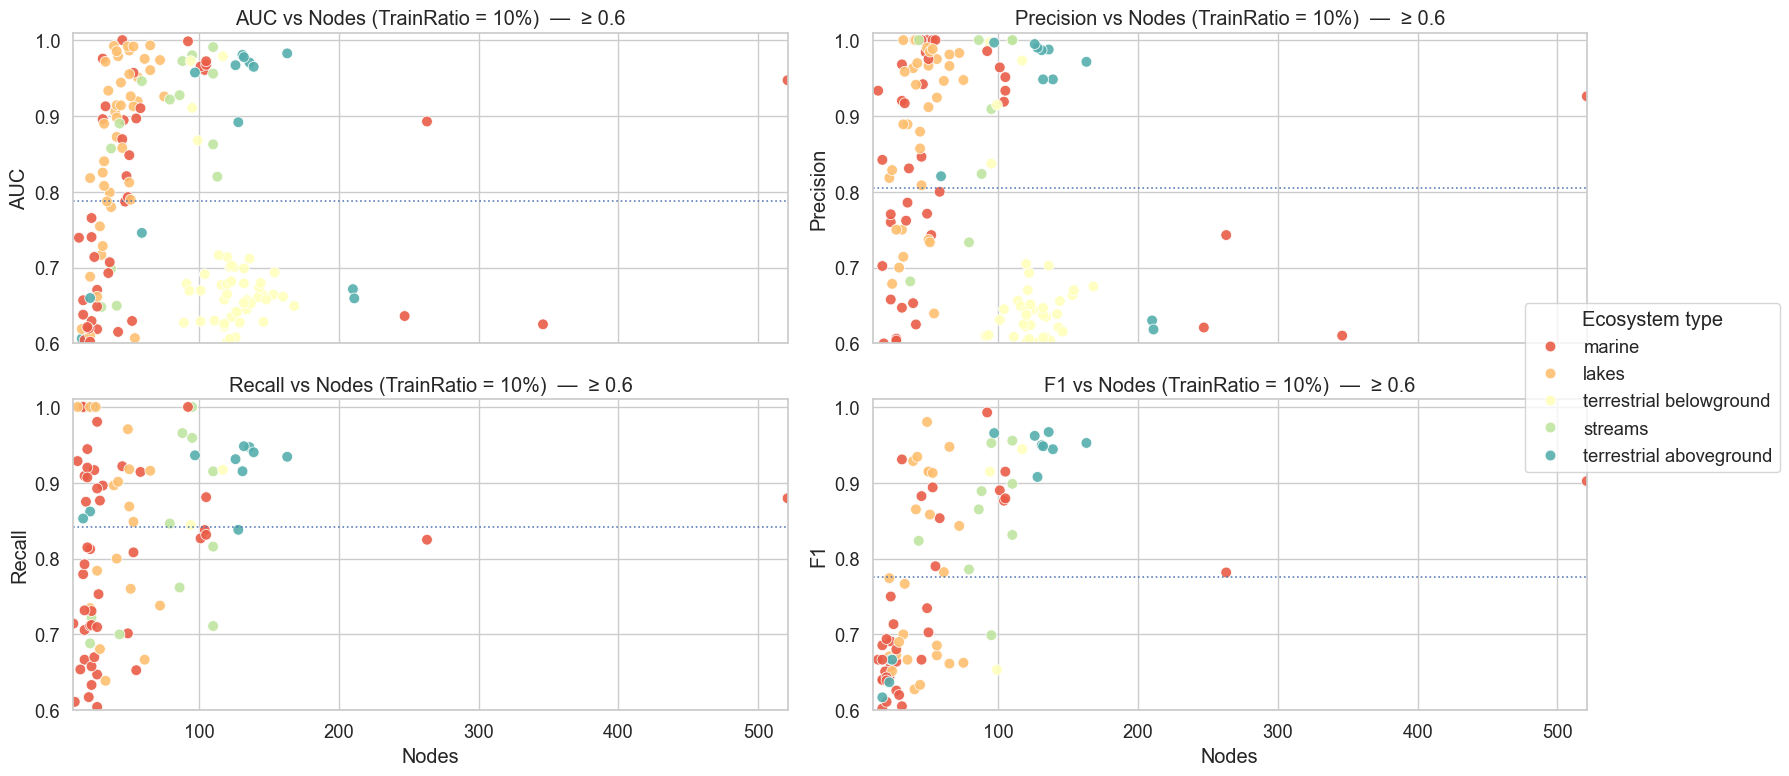

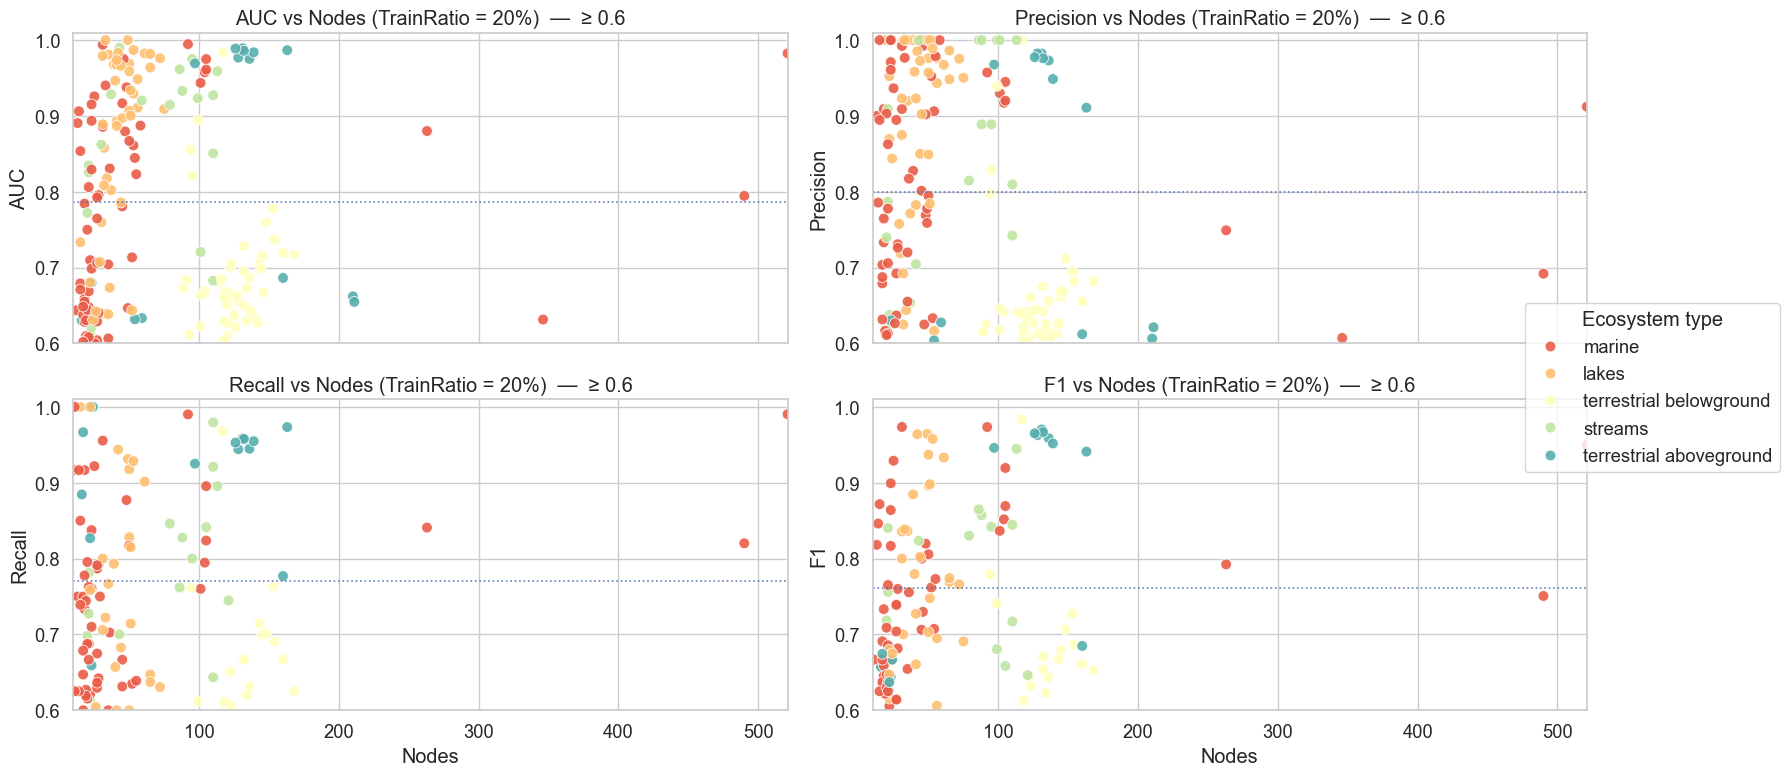

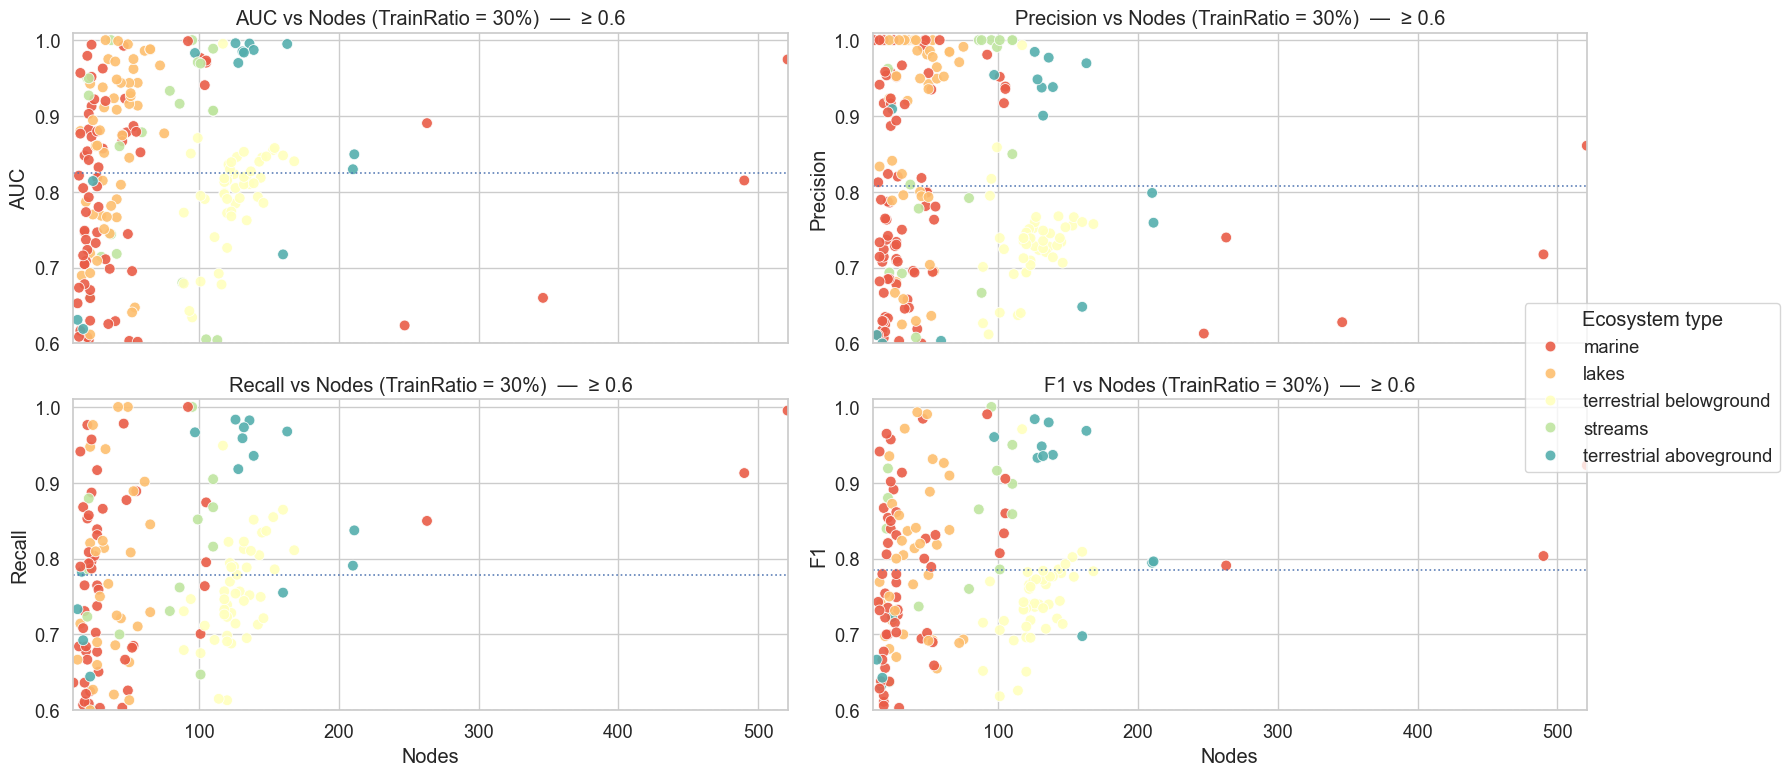

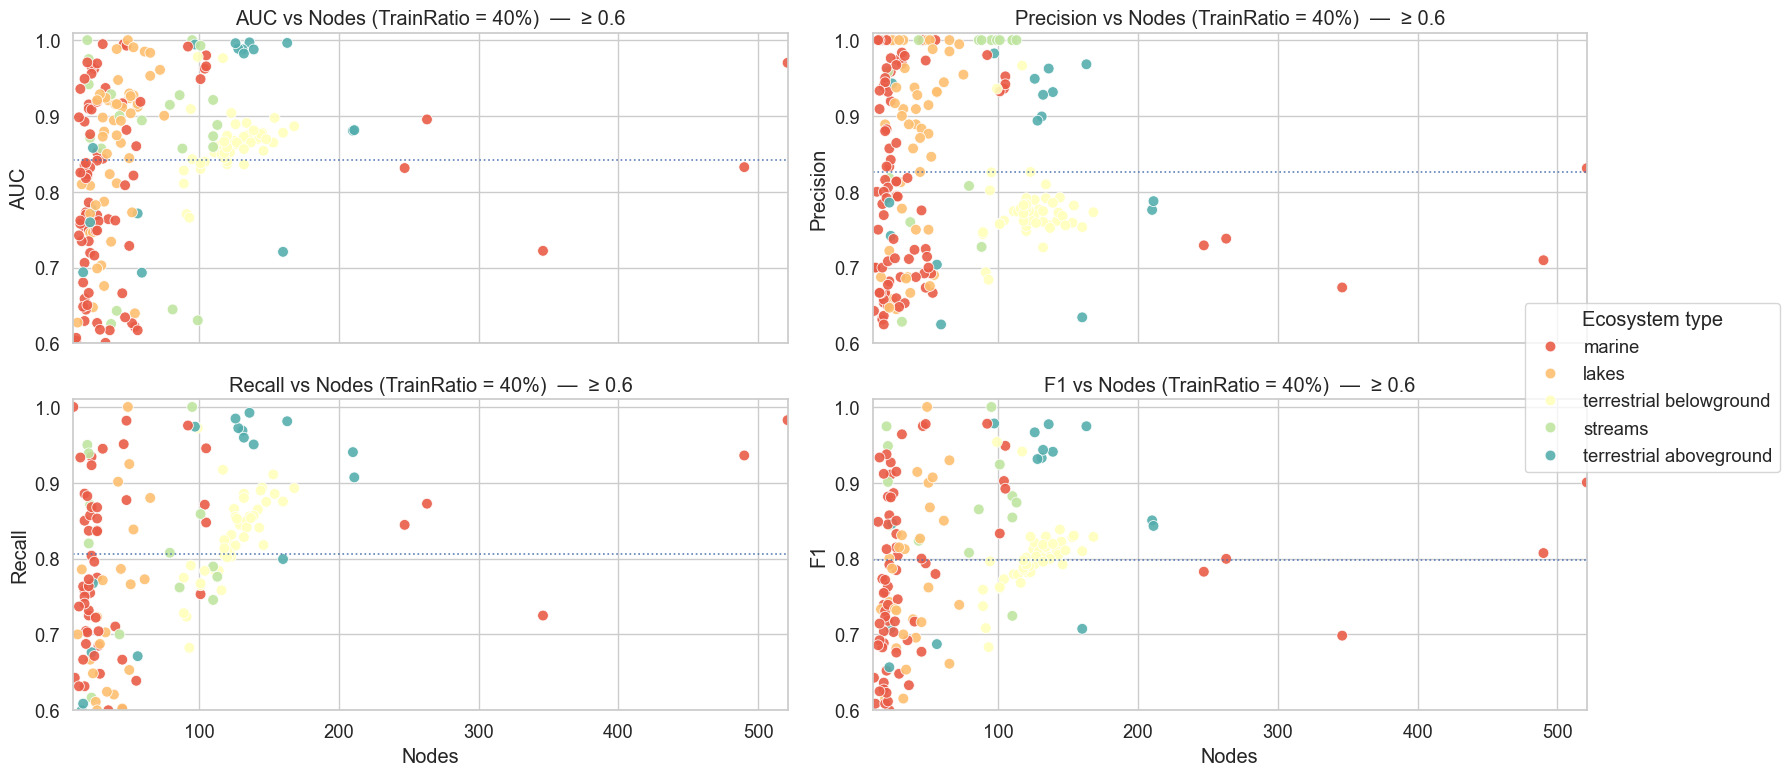

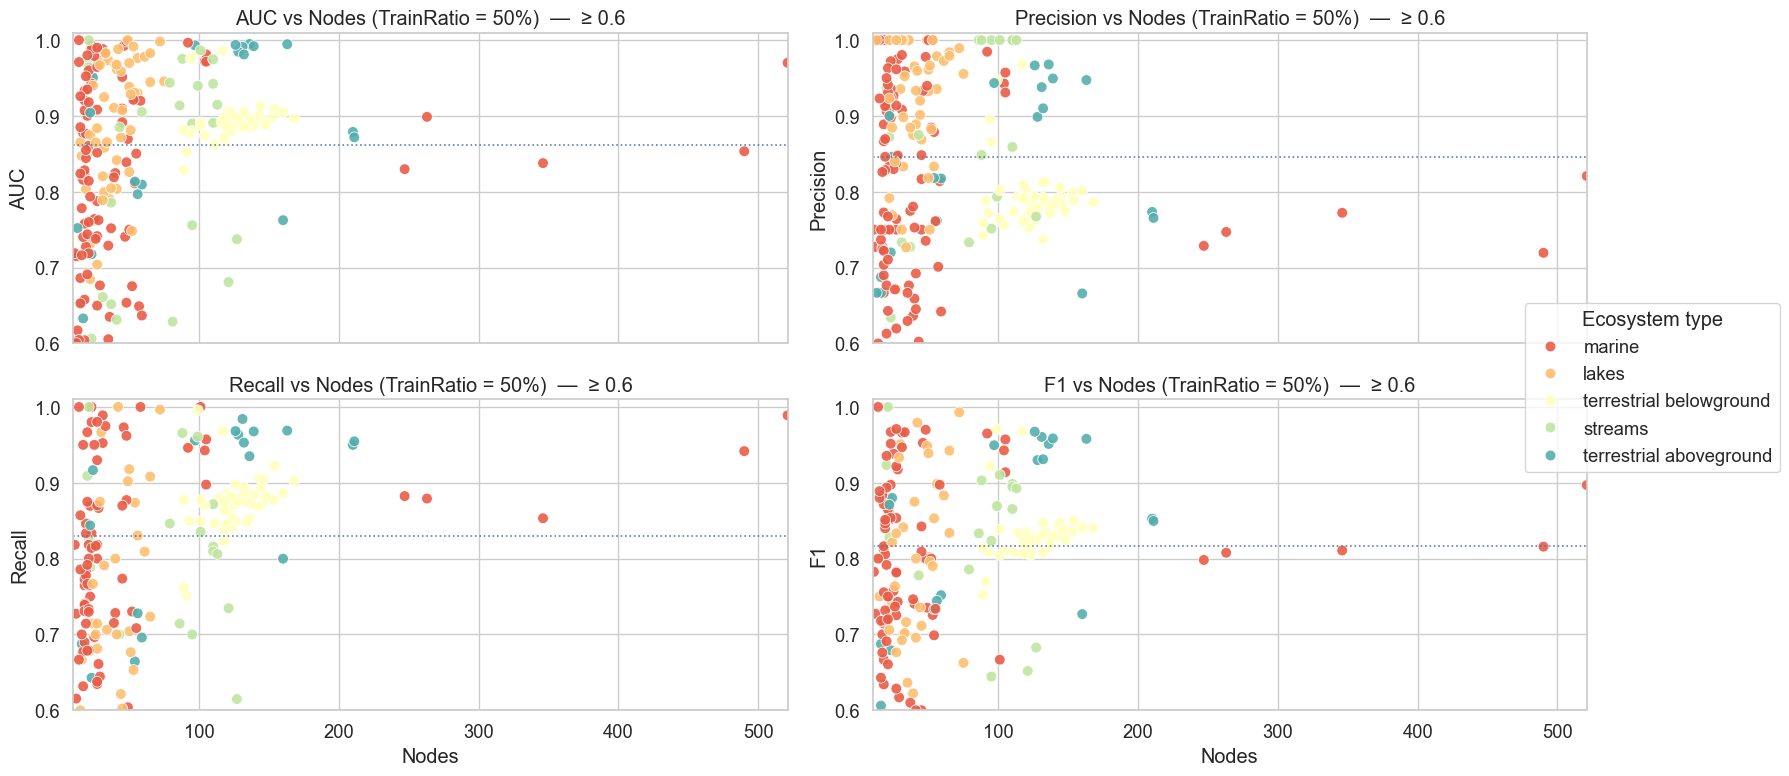

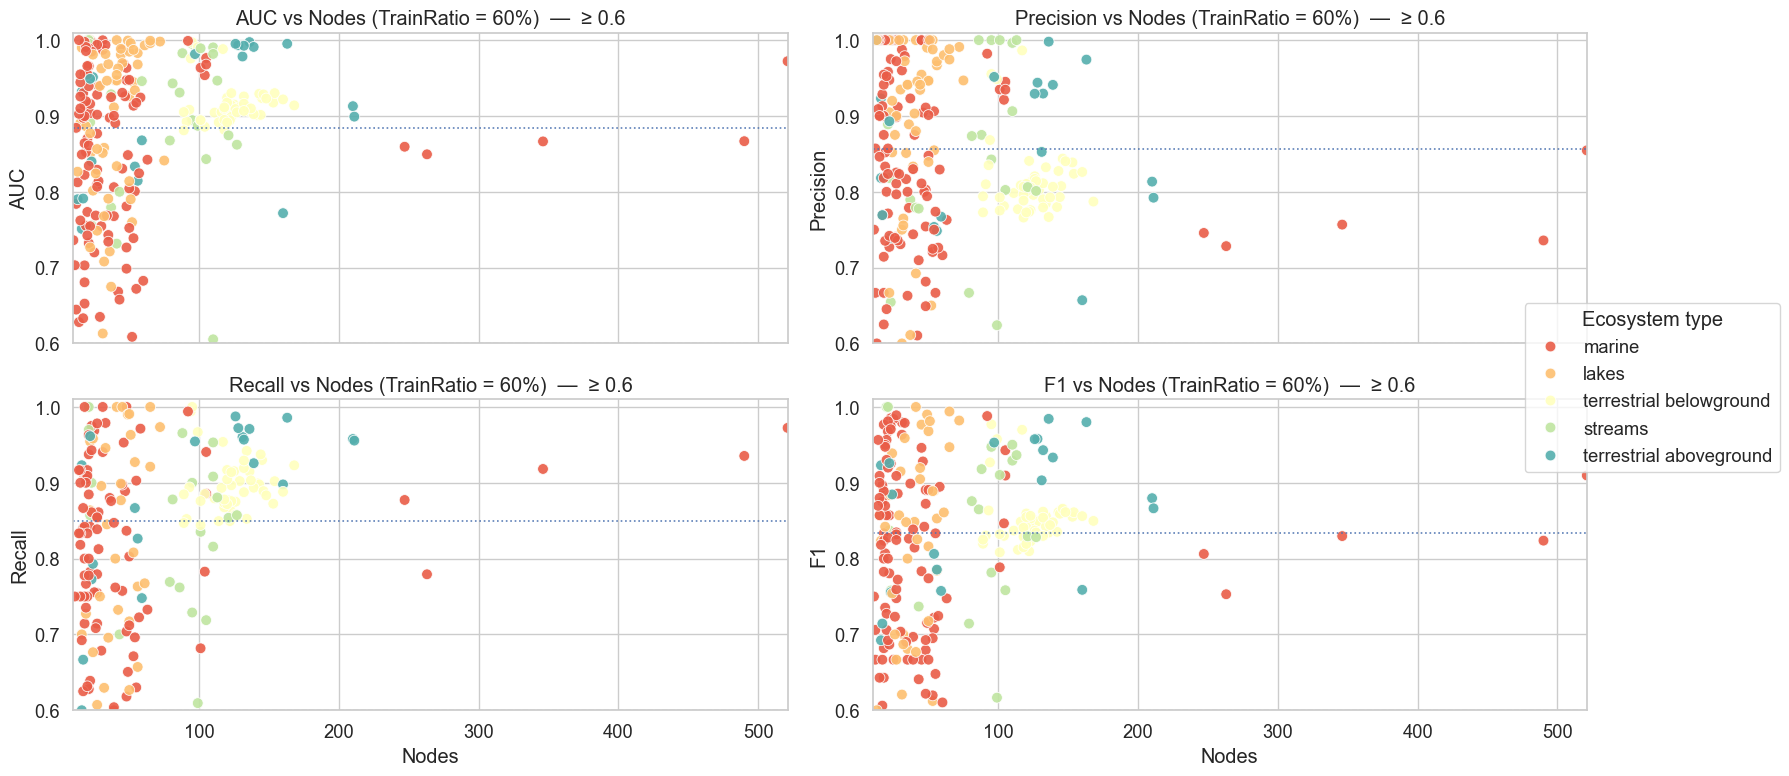

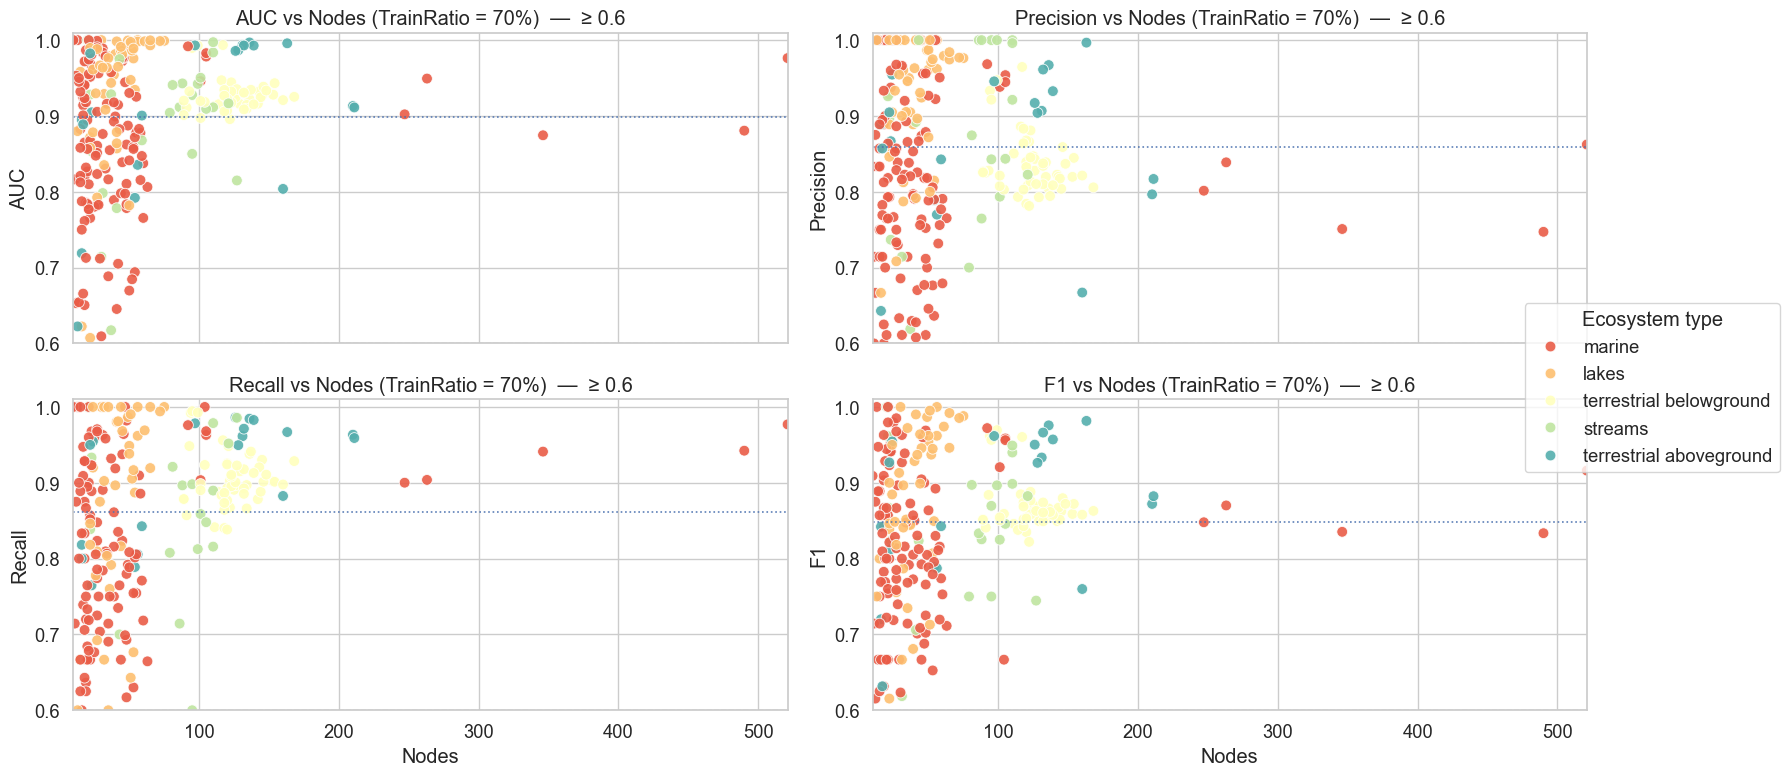

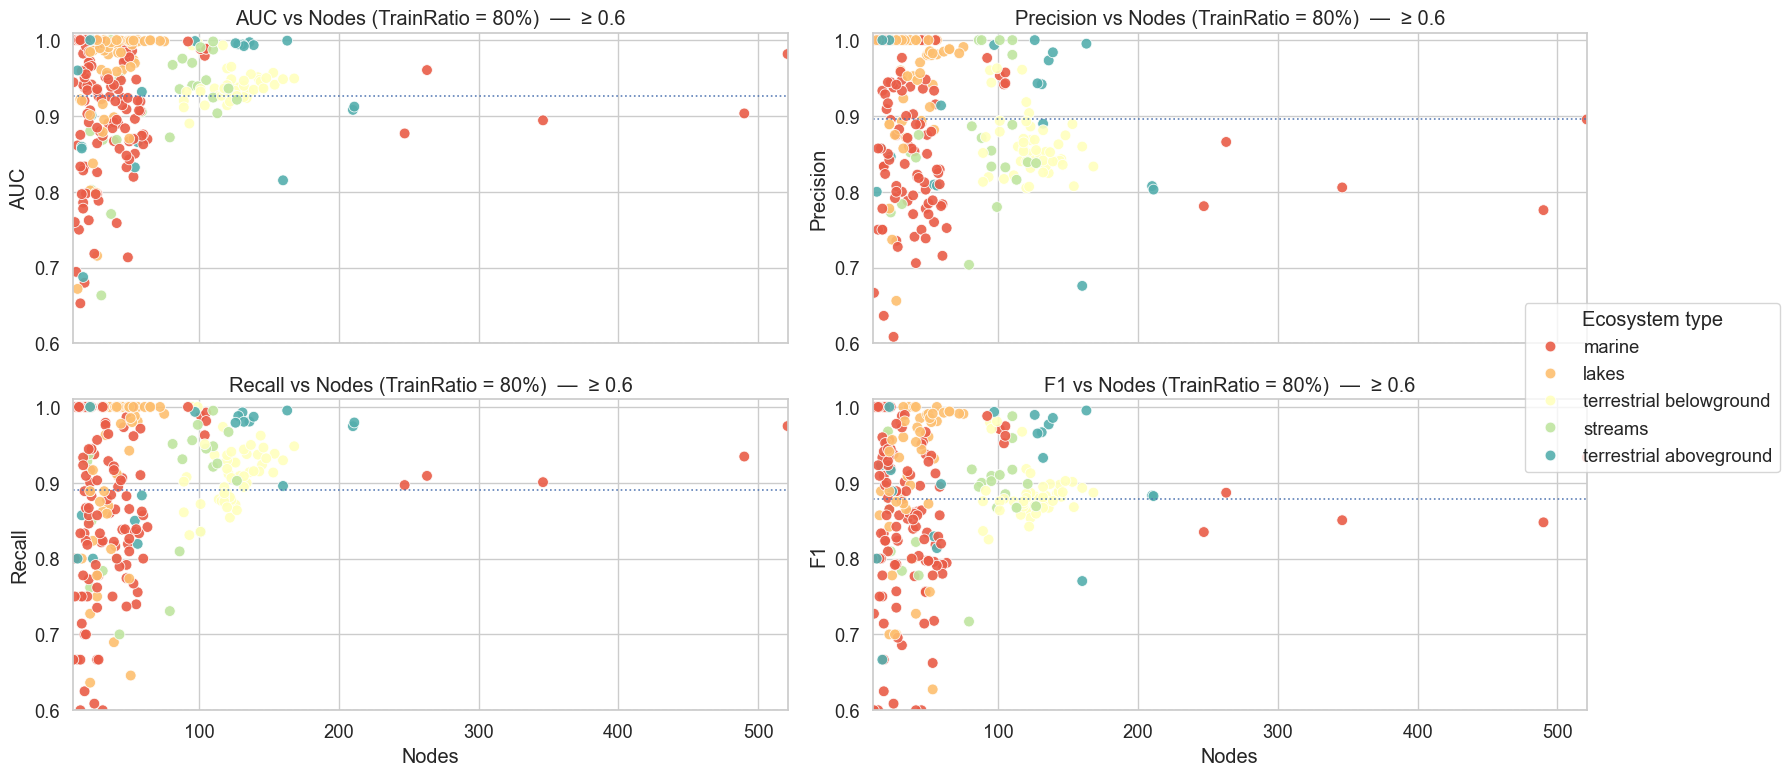

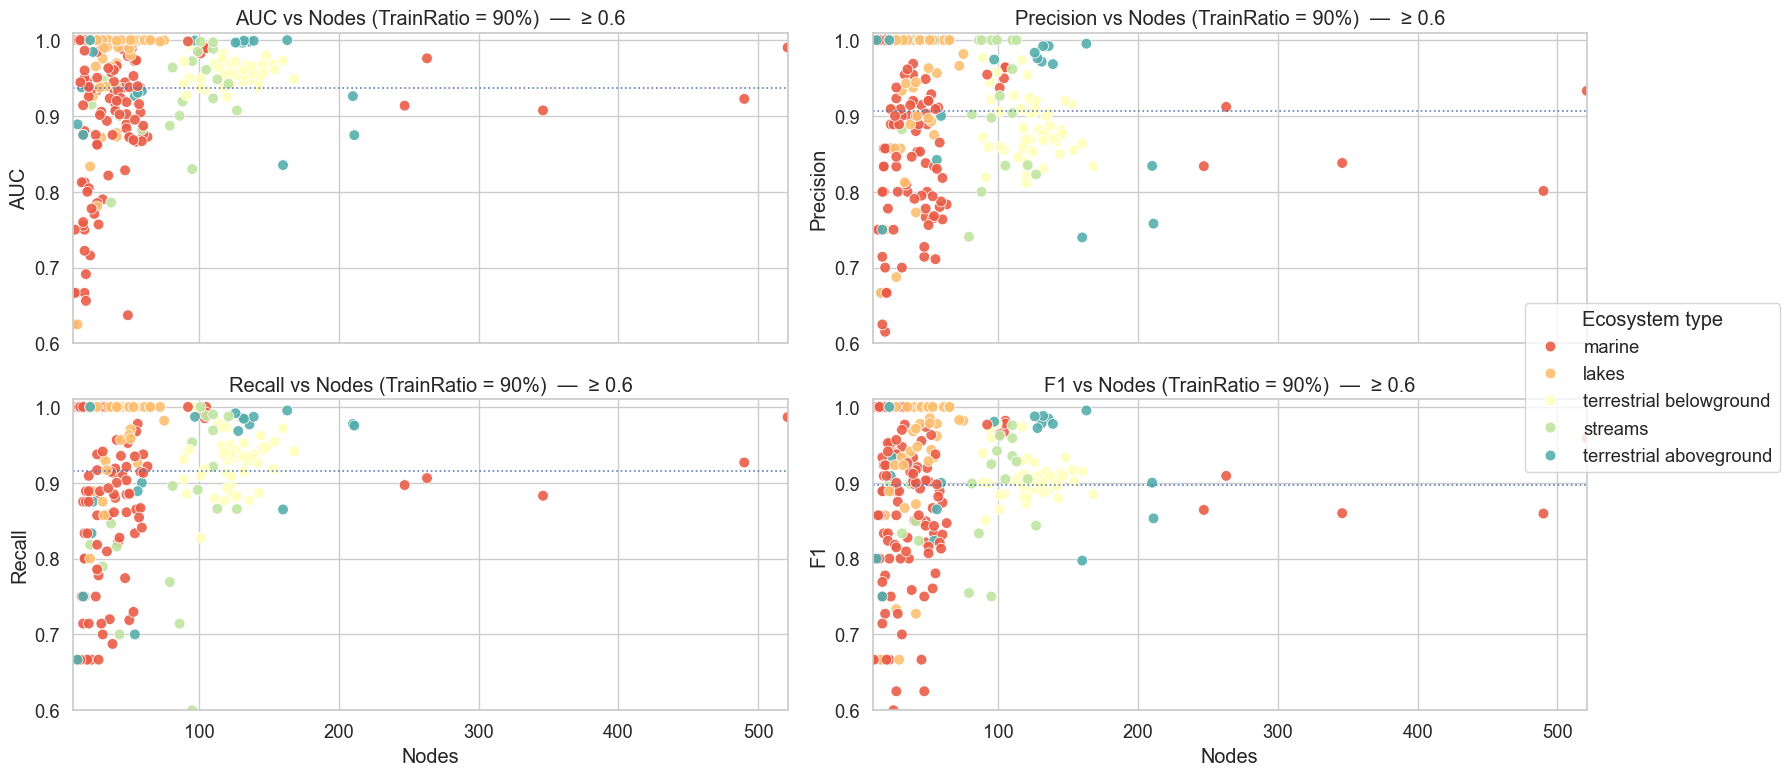

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Paths ===
results_dir = "../../src/matlab/data/result_sweep_train_ratios_10-90/prediction_scores_logs"
ecosystem_file = "../../src/matlab/data/foodwebs_mat/foodweb_metrics_ecosystem.csv"

# === Controls ===
MIN_NODES   = 1
USE_LOG_X   = False
METRIC_MIN  = 0.60   # show only foodwebs with metric >= this value
TRAIN_RATIOS = list(range(10, 100, 10))  # 10,20,...,90

metrics_to_plot = ["AUC", "Precision", "Recall", "F1"]
metric_aliases = {
    "AUC":        ["AUC", "auc"],
    "Precision":  ["Precision", "precision", "prec"],
    "Recall":     ["Recall", "recall", "tpr", "sensitivity"],
    "F1":         ["F1Score", "F1", "f1", "F1_Score"],
}

# === Load ecosystem metadata ===
df_ecosystem = pd.read_csv(ecosystem_file)

def _normalize(s: str) -> str:
    return (
        str(s).strip().lower()
        .replace(" ", "").replace(".", "").replace("-", "").replace("_", "")
    )

# robust node-count detection
node_candidates = {
    "nodes","n_nodes","num_nodes","species","numspecies","s","nodecount","speciescount"
}
norm_map = {_normalize(c): c for c in df_ecosystem.columns}
node_col = None
for k in node_candidates:
    if k in norm_map:
        node_col = norm_map[k]
        break
if node_col is None:
    raise RuntimeError("No node-count column found. Add one (e.g., 'nodes' or 'S').")

# === Load result CSVs and stack ONCE ===
csv_files = glob.glob(os.path.join(results_dir, "*_results_random.csv"))
if not csv_files:
    raise RuntimeError("No result CSV found. Check the path/pattern.")
dfs = []
for file in csv_files:
    df = pd.read_csv(file)
    df["Foodweb"] = os.path.basename(file).split("_results_")[0]
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)

# === Merge metadata (ecosystem + node count) ===
meta_cols = ["Foodweb", "ecosystem.type", node_col]
missing_cols = [c for c in meta_cols if c not in df_ecosystem.columns]
if missing_cols:
    raise RuntimeError(f"Missing columns in ecosystem metadata: {missing_cols}")
df_merged = pd.merge(df_all, df_ecosystem[meta_cols], on="Foodweb", how="left")

# === Filter by node count ===
df_merged[node_col] = pd.to_numeric(df_merged[node_col], errors="coerce")
df_merged = df_merged[df_merged[node_col] >= MIN_NODES].copy()

# Train ratio column numeric
df_merged["TrainRatio_num"] = pd.to_numeric(df_merged["TrainRatio"], errors="coerce")

# Global legend/palette and x-lims (consistent across all ratios)
eco_order = (
    df_merged[["Foodweb", "ecosystem.type"]]
    .drop_duplicates()
    .groupby("ecosystem.type").size()
    .sort_values(ascending=False).index.tolist()
)
palette = sns.color_palette("Spectral", n_colors=max(3, len(eco_order)))
x_all = df_merged[node_col].astype(float)
x_min, x_max = np.nanmin(x_all), np.nanmax(x_all)

def find_col(df, cands):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in cands:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    return None

sns.set_theme(style="whitegrid", font_scale=1.20)

for TRAIN_RATIO in TRAIN_RATIOS:
    # Accept 80 or 0.8 style
    tr = df_merged["TrainRatio_num"]
    mask_tr = np.isclose(tr, TRAIN_RATIO) | np.isclose(tr * 100.0, TRAIN_RATIO)
    subset = df_merged[mask_tr].copy()
    if subset.empty:
        print(f"[WARN] No rows for TrainRatio={TRAIN_RATIO}%. Skipping.")
        continue

    fig, axes = plt.subplots(2, 2, figsize=(18, 8), sharex=True)
    axes_map = {"AUC": axes[0, 0], "Precision": axes[0, 1], "Recall": axes[1, 0], "F1": axes[1, 1]}
    shared_handles = {}

    for Metric in metrics_to_plot:
        ax = axes_map[Metric]

        metric_col = find_col(subset, metric_aliases[Metric])
        if metric_col is None:
            ax.text(0.5, 0.5, f"{Metric} not found", ha="center", va="center", fontsize=14)
            ax.set_axis_off()
            continue

        tmp = subset.copy()
        tmp[metric_col] = pd.to_numeric(tmp[metric_col], errors="coerce")
        tmp = tmp.dropna(subset=[metric_col, node_col, "ecosystem.type", "Foodweb"])

        # average per foodweb
        meta_unique = df_ecosystem[["Foodweb", "ecosystem.type", node_col]].drop_duplicates()
        metric_avg = (
            tmp.groupby("Foodweb", as_index=False)[metric_col].mean()
              .rename(columns={metric_col: "MetricValue"})
              .merge(meta_unique, on="Foodweb", how="left")
              .dropna(subset=["MetricValue", node_col, "ecosystem.type"])
        )

        # threshold filter AFTER averaging
        display_df = metric_avg[metric_avg["MetricValue"] >= METRIC_MIN].copy()
        if display_df.empty:
            ax.text(0.5, 0.5, f"No {Metric} ≥ {METRIC_MIN}", ha="center", va="center", fontsize=14)
            ax.set_axis_off()
            continue

        g = sns.scatterplot(
            data=display_df,
            x=node_col, y="MetricValue",
            hue="ecosystem.type", hue_order=eco_order, palette=palette,
            s=60, alpha=0.9, edgecolor="white", linewidth=0.6, ax=ax
        )

        # reference lines
        if Metric.upper() == "AUC":
            ax.axhline(0.5, linestyle="--", linewidth=1, alpha=0.8)  # random baseline
        ax.axhline(display_df["MetricValue"].mean(), linestyle=":", linewidth=1.2, alpha=0.9)
        ax.axhline(METRIC_MIN, linestyle="--", linewidth=1.0, alpha=0.7, color="gray")

        # axes formatting
        if USE_LOG_X:
            ax.set_xscale("log"); ax.set_xlabel("Nodes (log scale)")
        else:
            ax.set_xlabel("Nodes")
        ax.set_ylabel(Metric)
        ax.set_title(f"{Metric} vs Nodes (TrainRatio = {int(TRAIN_RATIO)}%)  —  ≥ {METRIC_MIN}")
        ax.set_ylim(METRIC_MIN, 1.01)
        ax.set_xlim(x_min, x_max)

        # shared legend capture
        handles, labels = ax.get_legend_handles_labels()
        if labels and labels[0].lower() in {"ecosystem.type", "ecosystem type"}:
            handles, labels = handles[1:], labels[1:]
        for h, lbl in zip(handles, labels):
            if lbl not in shared_handles:
                shared_handles[lbl] = h
        leg = ax.get_legend()
        if leg is not None:
            leg.remove()

    # single legend for this figure
    ordered_labels = [lbl for lbl in eco_order if lbl in shared_handles]
    ordered_handles = [shared_handles[lbl] for lbl in ordered_labels]
    if ordered_handles:
        fig.legend(ordered_handles, ordered_labels, title="Ecosystem type",
                   loc="center right", frameon=True)

    plt.tight_layout(rect=[0, 0, 0.90, 1])
    plt.show()

## Hengill Dataset EDA

In [1]:
import pandas as pd

df = pd.read_csv("../../data/raw/Hengill_Dataset/Aug08_final_links.csv", low_memory=False)
df

,location,time,IS,temp,consumer,resource,con_mass,con_abun,res_mass,res_abun,source,con_taxonomy
0,Hengill,August 2008,1,22.7,Eukiefferiella minor,Achnanthes,0.041873,28.0,2.343333e-07,9.259091e+06,regional,species
1,Hengill,August 2008,1,22.7,Eukiefferiella minor,Amphora,0.041873,28.0,4.317500e-07,2.988570e+05,regional,species
2,Hengill,August 2008,1,22.7,Eukiefferiella minor,Cocconeis,0.041873,28.0,2.125000e-06,2.596395e+06,stream,species
3,Hengill,August 2008,1,22.7,Eukiefferiella minor,CPOM,0.041873,28.0,NaN,NaN,regional,species
4,Hengill,August 2008,1,22.7,Eukiefferiella minor,Cymbella,0.041873,28.0,1.980000e-07,2.390856e+05,stream,species
...,...,...,...,...,...,...,...,...,...,...,...,...
3787,Hengill,August 2008,16,14.5,Thienemanniella sp.,Nitzschia,0.036557,488.0,5.712000e-08,1.311567e+07,regional,species
3788,Hengill,August 2008,16,14.5,Thienemanniella sp.,Rhoicosphenia,0.036557,488.0,4.800000e-08,1.232675e+06,stream,group
3789,Hengill,August 2008,16,14.5,Thienemanniella sp.,Rhopalodia,0.036557,488.0,2.490000e-06,1.555051e+06,stream,group
3790,Hengill,August 2008,16,14.5,Thienemanniella sp.,Surirella,0.036557,488.0,7.300000e-07,5.183505e+05,regional,species


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3792 entries, 0 to 3791
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   location      3792 non-null   object 
 1   time          3792 non-null   object 
 2   IS            3792 non-null   int64  
 3   temp          3792 non-null   float64
 4   consumer      3792 non-null   object 
 5   resource      3792 non-null   object 
 6   con_mass      3792 non-null   float64
 7   con_abun      3792 non-null   float64
 8   res_mass      3134 non-null   float64
 9   res_abun      3134 non-null   float64
 10  source        3792 non-null   object 
 11  con_taxonomy  3792 non-null   object 
dtypes: float64(5), int64(1), object(6)
memory usage: 355.6+ KB


In [3]:
df.describe()

,IS,temp,con_mass,con_abun,res_mass,res_abun
count,3792.000000,3792.000000,3792.000000,3792.000000,3.134000e+03,3.134000e+03
mean,8.741297,14.930512,208.617567,905.025101,1.727719e-02,2.059807e+07
std,4.303606,6.081058,1717.243252,2322.692093,1.244029e-01,4.829286e+07
min,1.000000,5.100000,0.000411,0.058140,8.620000e-09,4.000000e+00
25%,5.000000,9.700000,0.024393,12.000000,1.563000e-07,4.106130e+05
50%,9.000000,14.500000,0.066200,64.000000,5.910000e-07,2.549744e+06
75%,12.000000,21.000000,0.216077,772.000000,3.884250e-06,1.273203e+07
max,16.000000,24.600000,24968.601530,20076.000000,5.056119e+00,2.908642e+08


In [7]:
df["consumer"].value_counts()

consumer
Simulium aureum               346
Simulium vittatum             318
Oligochaeta indet.            292
Micropsectra atrofasciata     264
Eukiefferiella minor          244
Radix balthica                218
Thienemanniella sp.           204
Rheocricotopus effesus        180
Potamophylax cingulatus       157
Orthocladius sp.              120
Limnophora riparia            119
Dicranota exclusa             115
Metriocnemus sp. B            100
Procladius islandicus         100
Chaetocladius sp.              85
Diamesa bertrami               85
Cricotopus sp. B               84
Salmo trutta                   83
Diamesa zernyi                 82
Capnia vidua                   77
Clinocera stagnalis            67
Sperchon glandulosus           64
Limoniinae indet.              56
Metriocnemus sp. A             55
Cricotopus sp. A               55
Macropelopia sp.               40
Prionocera turcica             38
Prosimulium ursinum            24
Hydrellia indet.               22
Eukie

In [2]:
df["resource"].value_counts()

resource
FPOM                       180
Achnanthes                 177
Meridion                   177
Diatoma                    165
Cocconeis                  164
                          ... 
Potamophylax cingulatus      2
Capnia vidua                 2
Helobdella stagnalis         1
Pisidium sp.                 1
Clinocera stagnalis          1
Name: count, Length: 62, dtype: int64

In [6]:
df["IS"].value_counts()

IS
16    334
7     329
4     319
9     293
12    292
14    289
5     281
11    280
13    256
6     249
10    243
3     231
1     223
8     173
Name: count, dtype: int64